In [5]:
"""
Data from: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html
"""

'\nData from: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html\n'

In [6]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

2.9.1


In [7]:
# Prepare data
image_dir = 'D:\Programming\Python\Data\cell_images'
x_train = []
x_anomaly = []

SIZE = 64

parasitised_img = os.listdir(image_dir + '\Parasitized')
for i, image_name in enumerate(parasitised_img):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_dir + '\Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        x_anomaly.append(np.array(image))

        
uninfected_img = os.listdir(image_dir + '\PNoninfected')
for i, image_name in enumerate(uninfected_img):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_dir + '\PNoninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        x_train.append(np.array(image))


from sklearn.utils import shuffle

train = np.array(x_train)/255.
bad_dataset = np.array(x_anomaly)/255.

train = shuffle(train, random_state=1993)
bad_dataset = shuffle(bad_dataset[:6000, :, :, :], random_state=1993)

train = train[8000:, :, :, :]

print(train.shape)
print(bad_dataset.shape)


(5779, 64, 64, 3)
(6000, 64, 64, 3)


In [8]:
# Build Autoencoder model

encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 

#Define encoder
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net.summary())
#print(encoder_net.input_shape)

#Define the decoder. 
#Start with the bottleneck dimension (encoder vector) and connect to dense layer 
#with dim = total nodes in the last conv. in the encoder. 
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),                   # Dence dim to help upsampling
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________

In [9]:
#Define and train the outlier detector. 

latent_dim = 1024  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.015


In [10]:
# train
# from alibi_detect.models.tensorflow.losses import elbo 
# evidence lower bound loss

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train,
       optimizer = adam,
       epochs=20,
       batch_size=4,
       verbose=True)

print("Current threshold value is: ", od.threshold)

C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1445/1445 [=] - 1169s 809ms/step - loss_ma: -19796.3004
Current threshold value is:  0.015


The instance score is: 0.004230281770889679
Is this image an outlier (0 for NO and 1 for YES)? 1


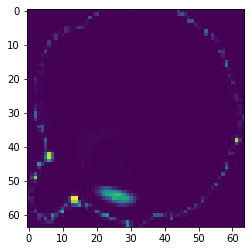

In [35]:
import random

img_num = random.randint(0, len(train))
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,1])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])

The instance score is: 0.0015540888253687045
Is this image an outlier (0 for NO and 1 for YES)? 0


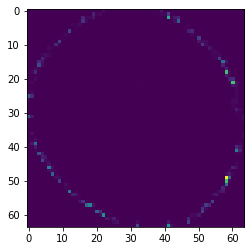

In [36]:
img_num = random.randint(0, len(train))
test_good_image = train[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_good_image[0])

test_good_image_recon = od.vae(test_good_image)
test_good_image_recon = test_good_image_recon.numpy()
plt.imshow(test_good_image_recon[0])

test_good_image_predict = od.predict(test_good_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
good_image_instance_score = test_good_image_predict['data']['instance_score'][0]
print("The instance score is:", good_image_instance_score)

good_image_feature_score = test_good_image_predict['data']['feature_score'][0]
plt.imshow(good_image_feature_score[:,:,1])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_good_image_predict['data']['is_outlier'][0])

Current threshld value is:  0.0027
(30, 64, 64, 3)
['instance_score', 'feature_score', 'is_outlier']


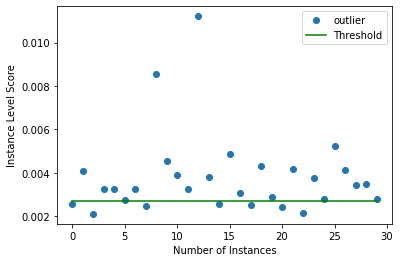

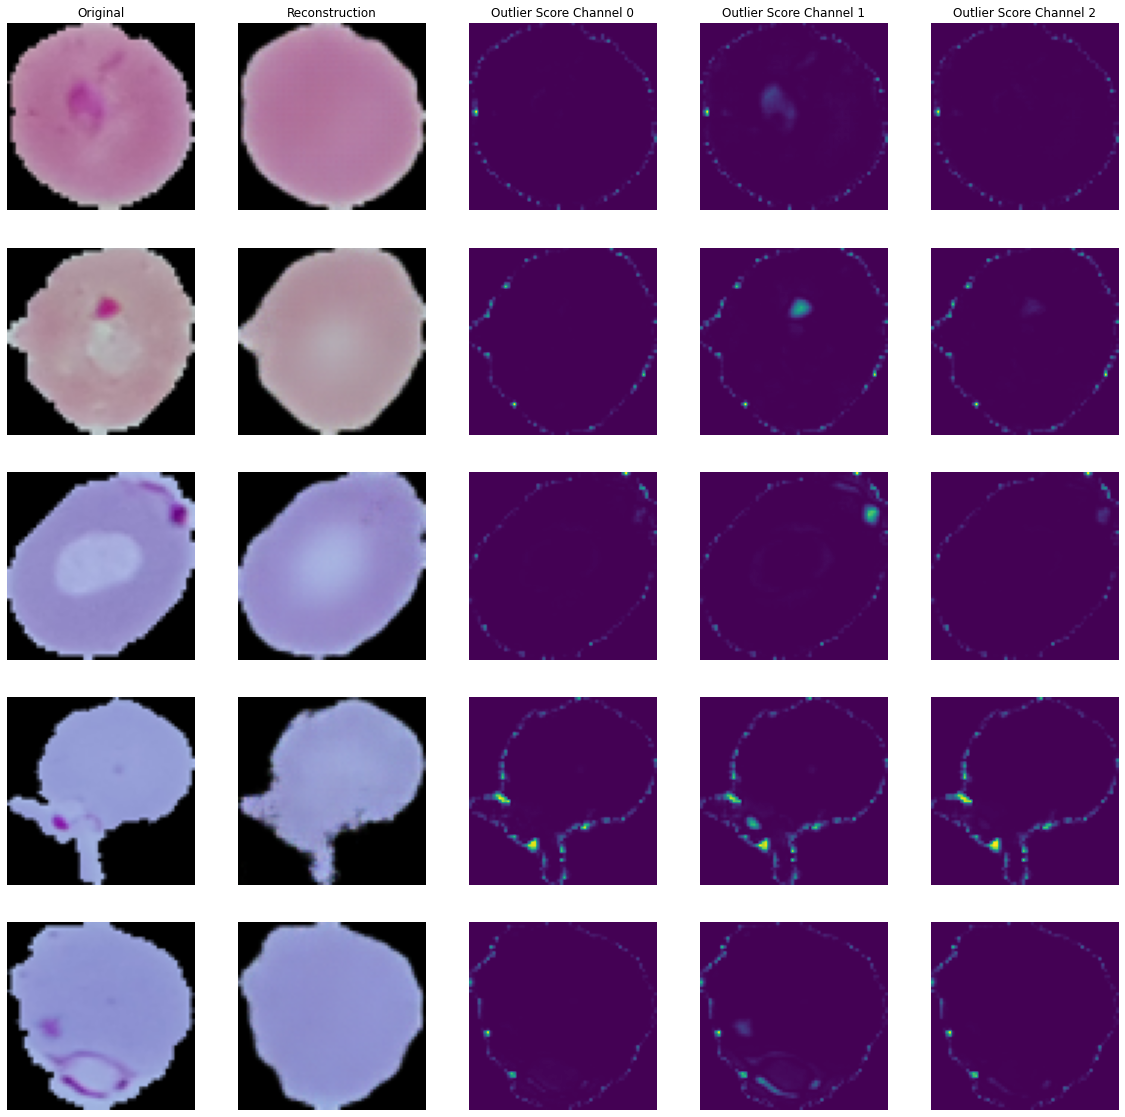

In [30]:
#You can also manually define the threshold based on your specific use case. 
od.threshold = 0.0027
print("Current threshld value is: ", od.threshold)

#Let us check it for multiple images
X = bad_dataset[:30]

print(X.shape)

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

# Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[2,4,5,8,10],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions